In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [90]:
styles = ['隸', '楷', '篆', '行', '草']
df = pd.read_csv('/data/data/data.csv', header=None, names = ["key", "character", "style", "author", "path"])
dataset_size = 166672
dataset_size = 2000
print(df.shape)

(166672, 5)


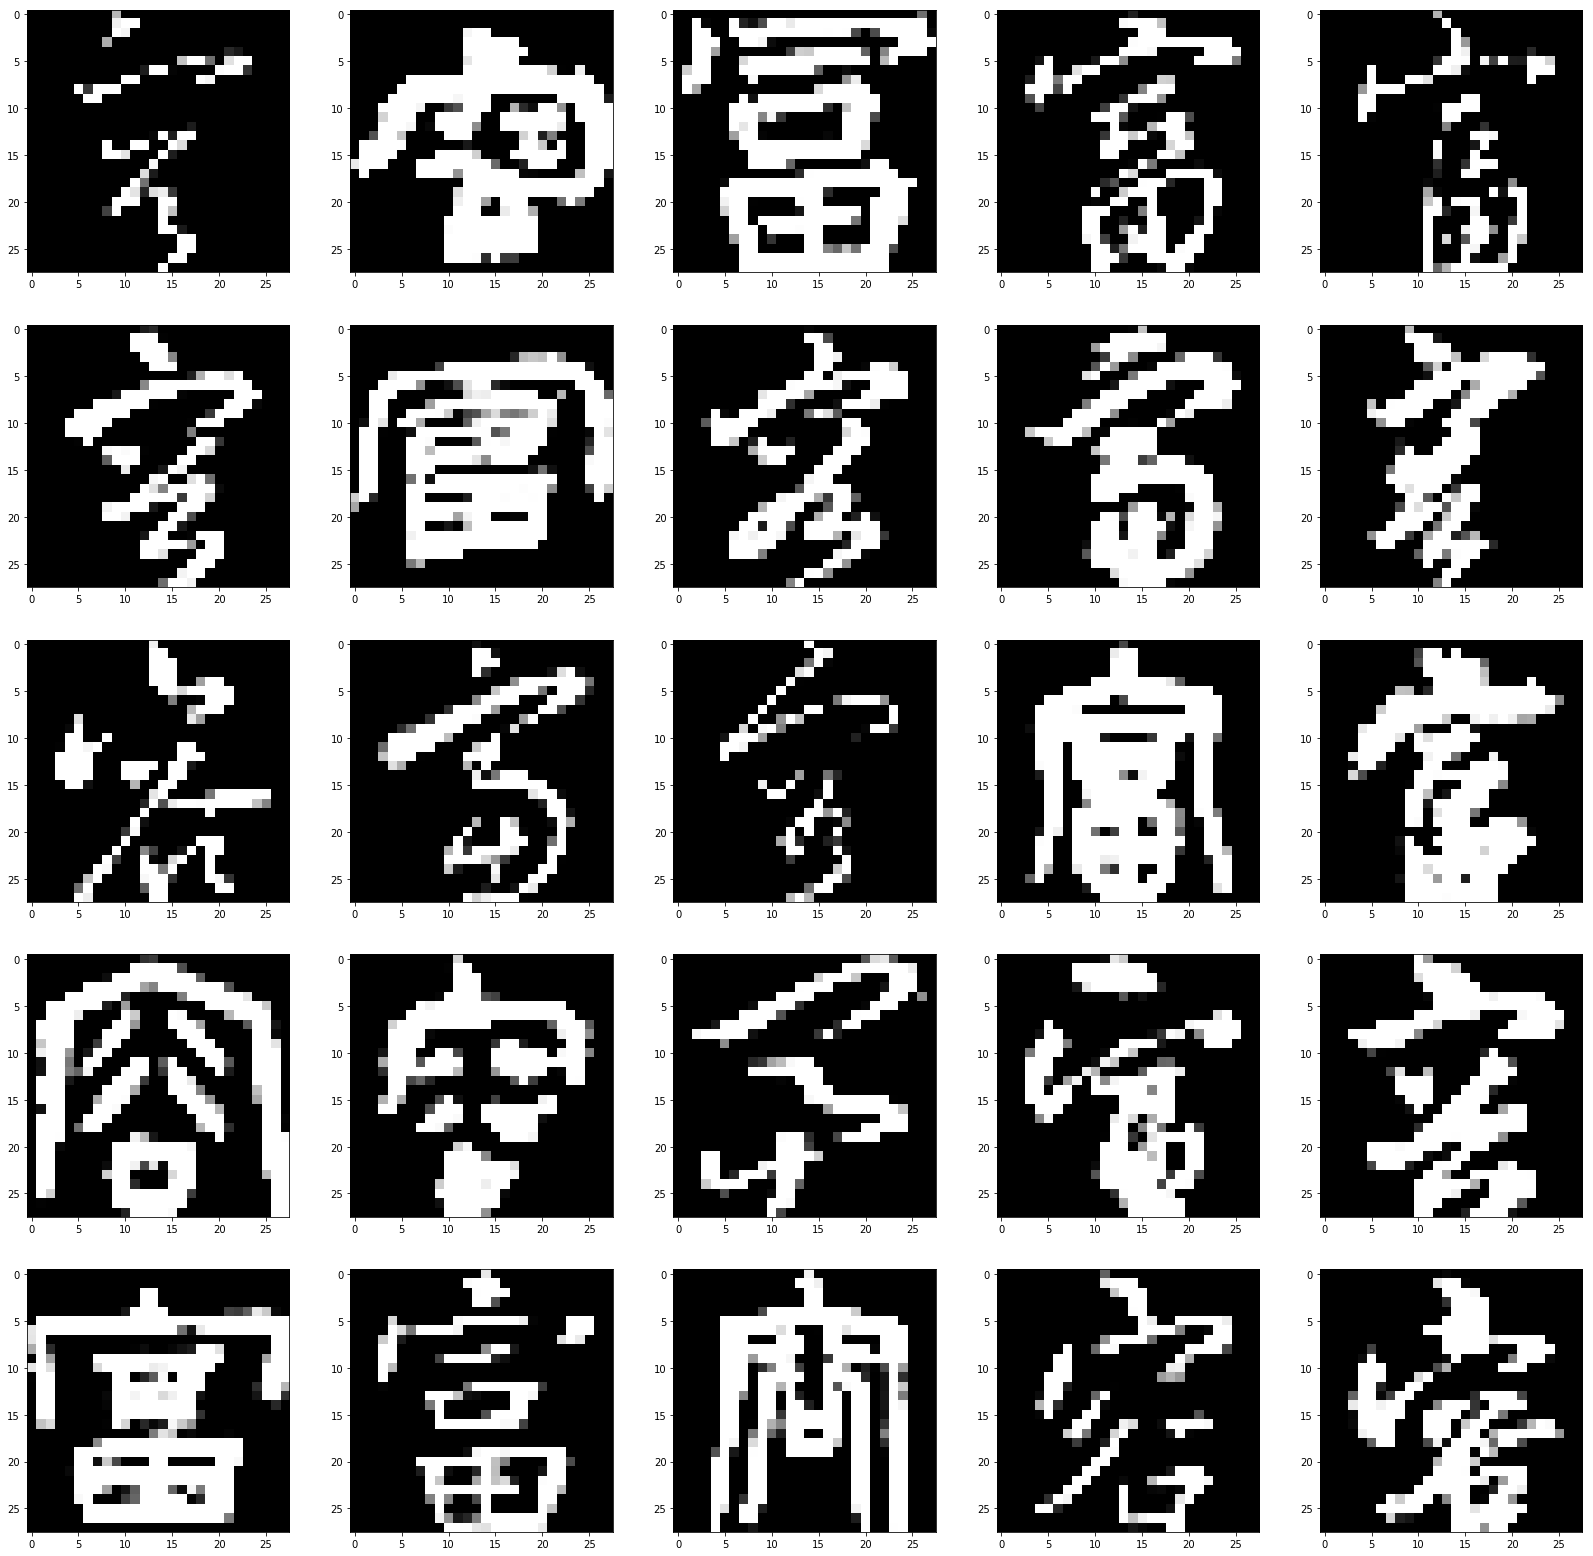

In [91]:
image_size = 28

styles = ['隸', '楷', '篆', '行', '草']
styles_mapping = tf.constant(styles)
styles_table= tf.contrib.lookup.index_table_from_tensor(mapping=styles_mapping, default_value=-1)

def getInput(fileList):
    files = tf.data.Dataset.from_tensor_slices(fileList)
    dataset = files.interleave(tf.data.TextLineDataset, 1)
    return dataset.map(_parse_function, num_parallel_calls=8)

def _parse_function(value):
    columns_default = [[""], [""], [""], [""], [""]]
    columns = tf.decode_csv(value, record_defaults=columns_default, field_delim=',')
    col_names = ["key", "character", "style", "author", "path"]
    features = dict(zip(col_names, columns))
    for f, tensor in features.items():
        if f == "style":
            features["style"] = styles_table.lookup(tensor)
        if f == "path":
            image_string = tf.read_file(tf.strings.join([tf.constant("/data/data"), tensor], '/'))
            image_decoded = tf.image.decode_png(image_string, channels=1)
            image_resized = tf.image.resize_images(image_decoded, [image_size, image_size])
            # image_standardized = tf.image.per_image_standardization(image_resized)
            image_reshaped = tf.reshape(image_resized, [image_size, image_size])
            features["image"] = image_reshaped
    return features

dataset = getInput(["/data/data/data.csv"])

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

shuffled_dataset = dataset.shuffle(buffer_size=100)
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

iterator = train_dataset.make_initializable_iterator()
el = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    tf.tables_initializer().run()
    plt.figure(figsize=(image_size, image_size))
    for i in range(25):
        record = sess.run(el)
        plt.subplot(5,5,i+1)
        plt.imshow(record["image"], cmap=plt.cm.binary)
    plt.show()

In [92]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features, [-1, image_size, image_size, 1], name = "ReshapeInput")

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=5)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  one_hot_labels = tf.reshape(tf.one_hot(labels, 5), [-1, 5])

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.softmax_cross_entropy(one_hot_labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

style_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn)

tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

train_iterator = train_dataset.make_initializable_iterator()
val_iterator = val_dataset.make_initializable_iterator()
train_element = train_iterator.get_next()
val_element = val_iterator.get_next()

def train_input_fn():
    dataset_inner = train_dataset.shuffle(buffer_size=100)
    dataset_inner = dataset_inner.batch(32)
    dataset_inner = dataset_inner.repeat(10)
    return dataset_inner.map(lambda x: ({"image": x["image"]}, tf.cast(x["style"], tf.int32)))

print("mapped dataset")
print(train_input_fn())

with tf.Session() as sess:
    sess.run(train_iterator.initializer)
    sess.run(val_iterator.initializer)
    tf.tables_initializer().run()

    #sample_train = train_input_fn()
    #sample_val = val_input_fn()
    
    #print(sample_train)
    #print(sample_val)
    
    #plt.figure(figsize=(image_size, image_size))
    #plt.subplot(1, 2, 1)
    #plt.imshow(sample_train[0], cmap=plt.cm.binary)
    #plt.subplot(1, 2, 2)
    #plt.imshow(sample_val[0], cmap=plt.cm.binary)
    #plt.show()

    # train one step and display the probabilties
    style_classifier.train(
        input_fn=train_input_fn,
        steps=10,
        hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00af3d3e10>, '_model_dir': '/tmp/tmpumSEGJ', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
mapped dataset
<DatasetV1Adapter shapes: ({image: (?, 28, 28)}, (?,)), types: ({image: tf.float32}, tf.int32)>


ValueError: Tensor("seed2:0", shape=(), dtype=int64, device=/device:CPU:0) must be from the same graph as Tensor("TakeDataset_79:0", shape=(), dtype=variant).